In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [3]:
" Loading data"

df = pd.read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
df.drop('No', axis=1, inplace=True)
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'
df['pollution'].fillna(0, inplace=True)
df = df[24:]

In [4]:
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


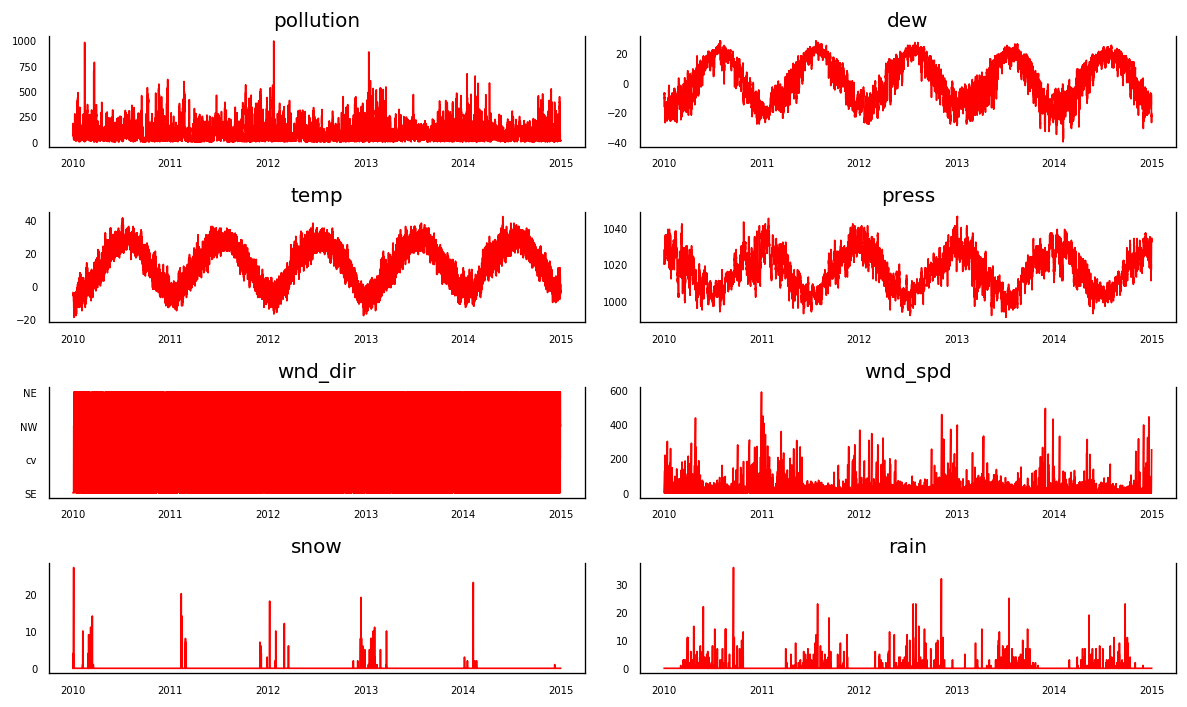

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Multivariate LSTM Forecast Model

#### LSTM Data Preparation

This involves framing the dataset as a supervised learning problem and normalizing the input variables

In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
# integer encode direction

values = df.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(values)


# specify the number of lag hours
n_hours = 3
n_features = 8

# frame as supervised learning
data_reframed = series_to_supervised(data_scaled, n_hours, 1)
print(data_reframed.shape)

(43797, 32)


In [8]:
data_reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
3,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0
6,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.111111,0.0,0.105634,0.485294,0.213115,0.581818,0.666667,0.014492,0.148148,0.0
7,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.148148,0.0,0.124748,0.485294,0.229508,0.600000,0.666667,0.017551,0.000000,0.0


#### Define and Fit Model


In this section, we will fit an LSTM on the multivariate input data.


In [9]:
# split into train and test sets
values = data_reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [10]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(8760, 24) 8760 (8760,)


In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


In [12]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 2s - loss: 0.0454 - val_loss: 0.0654
Epoch 2/50
 - 1s - loss: 0.0270 - val_loss: 0.0471
Epoch 3/50
 - 1s - loss: 0.0219 - val_loss: 0.0264
Epoch 4/50
 - 1s - loss: 0.0213 - val_loss: 0.0228
Epoch 5/50
 - 1s - loss: 0.0206 - val_loss: 0.0211
Epoch 6/50
 - 1s - loss: 0.0200 - val_loss: 0.0190
Epoch 7/50
 - 1s - loss: 0.0195 - val_loss: 0.0184
Epoch 8/50
 - 1s - loss: 0.0190 - val_loss: 0.0179
Epoch 9/50
 - 1s - loss: 0.0185 - val_loss: 0.0170
Epoch 10/50
 - 1s - loss: 0.0182 - val_loss: 0.0167
Epoch 11/50
 - 1s - loss: 0.0178 - val_loss: 0.0163
Epoch 12/50
 - 1s - loss: 0.0173 - val_loss: 0.0161
Epoch 13/50
 - 1s - loss: 0.0169 - val_loss: 0.0157
Epoch 14/50
 - 1s - loss: 0.0167 - val_loss: 0.0165
Epoch 15/50
 - 1s - loss: 0.0162 - val_loss: 0.0158
Epoch 16/50
 - 1s - loss: 0.0159 - val_loss: 0.0154
Epoch 17/50
 - 1s - loss: 0.0159 - val_loss: 0.0156
Epoch 18/50
 - 1s - loss: 0.0155 - val_loss: 0.0150
Epoch 19/50
 - 1s - loss

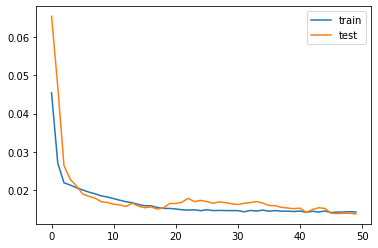

In [13]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Evaluate Model


In [14]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.365


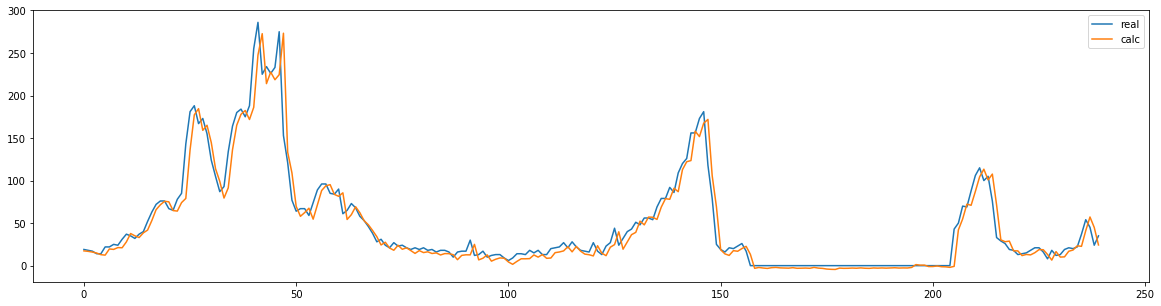

In [15]:
nb_jours = 10
nb_hours = 24
nb_total = nb_jours * nb_hours

plt.figure(figsize=(20,5))
plt.plot(inv_y[:nb_total],label='real')
plt.plot(inv_yhat[:nb_total],label='calc')
plt.legend()
plt.show()